In [3]:
# Import necessary libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
# Load dataset
data_path = 'combined_data.csv'  # Update with your actual path
df = pd.read_csv(data_path)
df.head()

,From Date,To Date,PM2.5,PM10,NO2,SO2,CO,Temp
0,01-01-2016 00:00,02-01-2016 00:00,104.05,131.63,69.91,41.12,2.78,23.26
1,02-01-2016 00:00,03-01-2016 00:00,75.84,104.38,47.84,28.14,1.73,23.95
2,03-01-2016 00:00,04-01-2016 00:00,78.44,111.12,32.53,19.14,2.15,23.52
3,04-01-2016 00:00,05-01-2016 00:00,110.34,166.90,26.10,15.35,2.91,22.64
4,05-01-2016 00:00,06-01-2016 00:00,117.52,168.11,24.88,14.63,3.06,22.72


In [5]:
# Step 1: Convert 'DateTime' to datetime format and extract useful features
# Convert 'DateTime' to a proper format and extract features
if 'DateTime' in df.columns:
    df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
    # Extract useful features
    df['Year'] = df['DateTime'].dt.year
    df['Month'] = df['DateTime'].dt.month
    df['Day'] = df['DateTime'].dt.day
    df['Hour'] = df['DateTime'].dt.hour
    # Drop the original 'DateTime' column
    df.drop(columns=['DateTime'], inplace=True)

# Fill missing values only in numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Check if the data has been cleaned and transformed
print(df.head())


          From Date           To Date   PM2.5    PM10    NO2    SO2    CO  \
0  01-01-2016 00:00  02-01-2016 00:00  104.05  131.63  69.91  41.12  2.78   
1  02-01-2016 00:00  03-01-2016 00:00   75.84  104.38  47.84  28.14  1.73   
2  03-01-2016 00:00  04-01-2016 00:00   78.44  111.12  32.53  19.14  2.15   
3  04-01-2016 00:00  05-01-2016 00:00  110.34  166.90  26.10  15.35  2.91   
4  05-01-2016 00:00  06-01-2016 00:00  117.52  168.11  24.88  14.63  3.06   

    Temp  
0  23.26  
1  23.95  
2  23.52  
3  22.64  
4  22.72  


In [6]:
# Step 2: Calculate AQI for PM2.5 and PM10

# AQI breakpoints for PM2.5 and PM10 (US EPA standards)
pm25_breakpoints = [
    (0, 12, 0, 50), (12.1, 35.4, 51, 100), (35.5, 55.4, 101, 150),
    (55.5, 150.4, 151, 200), (150.5, 250.4, 201, 300), (250.5, 350.4, 301, 400),
    (350.5, 500.4, 401, 500)
]

pm10_breakpoints = [
    (0, 54, 0, 50), (55, 154, 51, 100), (155, 254, 101, 150),
    (255, 354, 151, 200), (355, 424, 201, 300), (425, 504, 301, 400),
    (505, 604, 401, 500)
]

# Function to calculate AQI based on concentration and breakpoints
def calculate_aqi(concentration, breakpoints):
    for bp in breakpoints:
        if bp[0] <= concentration <= bp[1]:
            return ((bp[3] - bp[2]) / (bp[1] - bp[0])) * (concentration - bp[0]) + bp[2]
    return None

# Apply the AQI calculation for PM2.5 and PM10
df['AQI_PM25'] = df['PM2.5'].apply(lambda x: calculate_aqi(x, pm25_breakpoints))
df['AQI_PM10'] = df['PM10'].apply(lambda x: calculate_aqi(x, pm10_breakpoints))

# Take the maximum AQI value from PM2.5 and PM10 as the final AQI
df['AQI'] = df[['AQI_PM25', 'AQI_PM10']].max(axis=1)

# Drop temporary columns
df.drop(columns=['AQI_PM25', 'AQI_PM10'], inplace=True)

# Remove non-numeric columns
df = df.select_dtypes(include=[np.number])

In [7]:
# Step 3: Prepare Data for Machine Learning Model

# Features (X) and Target (y)
X = df.drop(columns=['AQI'])  # Use all features except AQI
y = df['AQI']  # Target variable

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Step 4: Train a Random Forest Model to Predict AQI

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Save the trained model to a file
joblib.dump(model, 'aqi_model.pkl')

print("Model training complete. Model saved as 'aqi_model.pkl'.")

Model training complete. Model saved as 'aqi_model.pkl'.


In [9]:
# Step 5: Evaluate the model on test data
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 0.41787570141882047
Root Mean Squared Error (RMSE): 4.270932625453508


In [10]:
# Step 6: Test the model with an example input
example_input = X_test.iloc[0:1]  # Take the first example from the test set
example_prediction = model.predict(example_input)
print("Example input:")
print(example_input)
print(f"Predicted AQI: {example_prediction[0]}")

Example input:
      PM2.5    PM10    NO2    SO2    CO   Temp
1029  63.98  127.99  10.13  27.24  1.41  35.73
Predicted AQI: 155.34199894625937


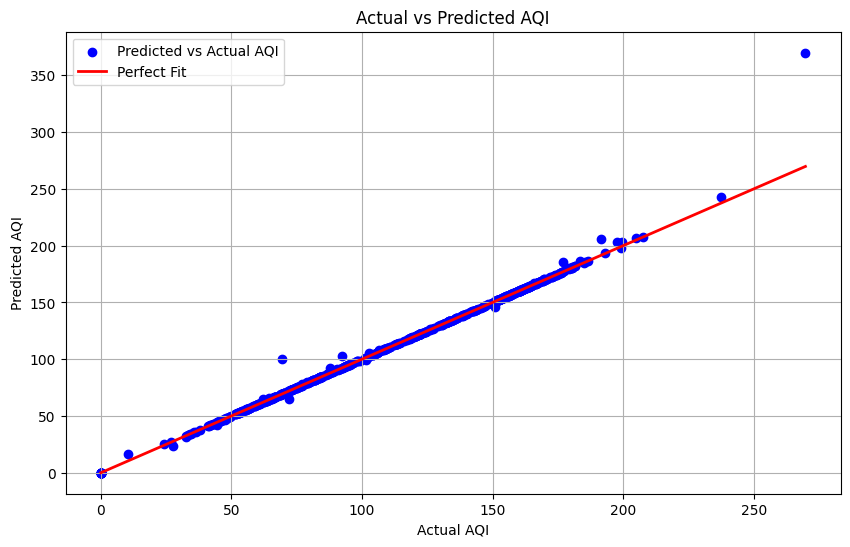

In [11]:
# Step 7: Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual AQI')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Perfect Fit')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
print("\nEnter the values for the following features:")
pm25_input = float(input("PM2.5 value: "))
pm10_input = float(input("PM10 value: "))
no2_input = float(input("NO2 value: "))
co_input = float(input("CO value: "))
so2_input = float(input("SO2 value: "))
temp_input = float(input("Temperature value: "))

# Get current date and time for Year, Month, Day, and Hour
now = datetime.now()

# Create a DataFrame for the user input
user_input = pd.DataFrame({
    'PM2.5': [pm25_input],
    'PM10': [pm10_input],
    'NO2': [no2_input],
    'CO': [co_input],
    'SO2': [so2_input],
    'Temp': [temp_input],
    'Year': [now.year],  # Use current year
    'Month': [now.month],  # Use current month
    'Day': [now.day],  # Use current day
    'Hour': [now.hour]  # Use current hour
})

# Ensure columns in user_input match those in X
user_input = user_input[X.columns]  # Reorder/adjust columns to match X

# Predict AQI for the user input
user_prediction = model.predict(user_input)
print(f"\nPredicted AQI for the given input: {user_prediction[0]}")



Enter the values for the following features:
PM2.5 value: 45.5
PM10 value: 120
NO2 value: 35
CO value: 0.9
SO2 value: 10
Temperature value: 25.5

Predicted AQI for the given input: 125.55244723618092


In [13]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.3.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, fastai, imbalanced-learn, librosa, mlxtend, skl2onnx, sklearn-pandas, yellowbrick


In [14]:
!pip install onnx
!pip install skl2onnx

In [15]:
import onnx
import skl2onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Convert model to ONNX format
initial_type = [('float_input', FloatTensorType([None, X.shape[1]]))]
onnx_model = convert_sklearn(model, initial_types=initial_type)

# Save the ONNX model
with open('aqi_model.onnx', 'wb') as file:
    file.write(onnx_model.SerializeToString())